## Búsqueda en espacio de estados

(Adaptado de Russell and Norvig (2016), cap. 3.

### Objetivo

Los problemas de búsqueda de soluciones son los más antiguos en la historia de la inteligencia artificial. Existen muchos métodos, pero aquí nos enfocaremos en la creación de un árbol de estados y estudiaremos algunas estrategias para la búsqueda de una solución en este espacio.

### Secciones

Desarrollaremos la explicación de la siguiente manera:

1. Presentación de un problema de ejemplo.
* Implementación del problema en Python.
* Definición de árboles de búsqueda y su implementación en Python.
* Estrategias de búsqueda y su implementación en Python.

### Problema de ejemplo

El siguiente problema se conoce como las *ocho reinas*, que consiste en poner ocho reinas en un tablero de ajerdez de tal manera que ninguna pueda atacar a las demás. 

En el siguiente tablero hay siete reinas. ¿Es esta una situación admisible? ¿Cuál puede ser una solución al problema?

<img src="./imagenes/ocho_reinas.png" width="230">

¿Cómo definimos el *entorno*? Este puede representarse como una colección de estados, donde cada uno de ellos representa el tablero con cero o más reinas. Por su parte, las acciones del agente consisten en poner una reina en una casilla vacía del tablero (aunque no todas serán *aplicables*).

**Ejercicio 1:**

De acuerdo a la formulación de entornos hecha durante la clase, ¿cuáles características considera usted que  tiene el *entorno* en este problema?

- [X] Completamente observable o Parcialmente observable
- Agente único o Multiagente
- Determinista o Estocástico
- Episódico o secuencial
- Estático o dinámico
- Discreto o continuo
- Conocido o desconocido

La **definición formal** del problema se hace con base en la definición de las siguientes características:

* **Estado inicial**: Situación del entorno desde la cual el agente comienza a resolver el problema. En nuestro ejemplo, el estado inicial es el tablero vacío.

* **Posibles acciones**: Descripción de las posibles acciones del agente en el entorno, dado un estado `s`. Estas acciones se llaman las *acciones aplicables* en `s`. En nuestro problema, dado un estado con $k$ reinas ($k<8$), las acciones aplicables son poner una reina en una de las casillas vacías que no es atacada por ninguna de las otras reinas.

* **Función de transiciones**: Descripción del entorno que resulta de la ejecución de una de las acciones del agente. Junto con el estado inicial y las posibles acciones, la función de transiciones define el *espacio de estados* del problema. En nuestro ejemplo, la función toma un tablero con $k$ reinas ($k<8$) y devuelve un tablero con $k+1$ reinas.

* **Prueba de satisfacción del objetivo**: Es una prueba que permite determinar si un estado es un *estado objetivo* en el cual se resuelve el problema. Esta prueba puede contener una colección de estados objetivo (para chequear si el estado es uno de ellos) o puede estar dada en términos de una condición explícita que debe cumplir un estado. En nuestro ejemplo, la prueba debe verificar la condición de si un tablero dado contiene ocho reinas en el cual niguna puede atacar a la otra.

* **Función de costo**: Determina el costo numérico asociado a cada camino entre estados. En nuestro ejemplo, dicha función no es esencial, pero consideraremos que cada acción tiene el mismo costo, de tal manera que la función de costo es la cantidad de acciones realizadas (siempre devolverá el valor de 8 en cualquier solución). 


**Implementación del problema**

Implementaremos el problema de las ocho reinas mediante una clase en Python.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from random import choice
import copy

%matplotlib inline

In [2]:
class ocho_reinas:
    
    def estado_inicial(self):
        return np.matrix([[0]*8]*8)
    
    def pintar_estado(self, estado):
        # Dibuja el tablero correspondiente al estado
        # Input: estado, que es una 8-lista de 8-listas
        fig, axes = plt.subplots()

        # Dibujo el tablero
        step = 1./8
        offset = 0.001
        tangulos = []

        # Borde del tablero
        tangulos.append(patches.Rectangle((0,0),0.998,0.998,\
                                          facecolor='cornsilk',\
                                         edgecolor='black',\
                                         linewidth=2))

        # Creo los cuadrados oscuros en el tablero
        for i in range(4):
            for j in range(4):
                tangulos.append(
                    patches.Rectangle(
                                      (2 * i * step, 2 * j * step), \
                                       step - offset, \
                                       step,\
                                       facecolor='lightslategrey')\
                                       )
                tangulos.append(
                    patches.Rectangle(
                                      (step + 2 * i * step, (2 * j + 1) * step), \
                                       step - offset, \
                                       step,\
                                       facecolor='lightslategrey')\
                                       )

        # Creo las líneas del tablero
        for j in range(8):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, locacion), 1, 0.008],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(locacion, 0), 0.008, 1],\
                    facecolor='black'))

        for t in tangulos:
            axes.add_patch(t)

        # Cargando imagen de la reina
        arr_img = plt.imread("./imagenes/reina.png", format='png')
        imagebox = OffsetImage(arr_img, zoom=0.048)
        imagebox.image.axes = axes
    
        offsetX = 0.065
        offsetY = 0.065
        for i in range(8):
            for j in range(8):
                if estado[j, i] == 1:
                    # print("Reina en (" + str(i) + ", " + str(j) + ")")
                    Y = 7 - j
                    X = i
                    # print("(" + str(X) + ", " + str(Y) + ")")
                    ab = AnnotationBbox(
                        imagebox, 
                        [(X*step) + offsetX, (Y*step) + offsetY], 
                        frameon=False)
                    axes.add_artist(ab)
        
        axes.axis('off')
        return axes
    
    def acciones_aplicables(self, estado):
        # Devuelve una lista de parejas que representan
        # las casillas vacías en las que es permitido
        # poner una reina adicional
        # Input: estado, que es una np.matrix(8x8)
        # Output: lista de indices (x,y)
        indices = [(x, y) for x in range(8) for y in range(8)]
        indices_bloqueados = []
        for x in range(8):
            for y in range(8):
                if estado[y, x]==1:
                    #print("Reina encontrada en", x, y)
                    # Encuentra una reina
                    # Elimina la fila
                    #print("Bloqueando filas...")
                    indices_bloqueados += [(i, y) for i in range(8)]
                    # Elimina la columna
                    #print("Bloqueando columnas...")
                    indices_bloqueados += [(x, i) for i in range(8)]
                    # Elimina las diagonales \
                    # print("\nBloqueando diagonales...")
                    dif = np.abs(x-y)
                    offset_x = 0
                    offset_y = 0
                    for i in range(1, 8 - dif):
                        if (y + i) == 8:
                            offset_x = - (x + i)
                            offset_y = dif
                        if (x + i) == 8:
                            offset_x = dif
                            offset_y = - (y + i)
                        xB = (x + i + offset_x) % 8
                        yB = (y + i + offset_y) % 8
                        # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                        indices_bloqueados.append((xB, yB))
                    # Elimina las transversales /
                    # print("\nBloqueando transversales...")
                    dif1 = np.abs((7-x)-y)
                    # print("\n Dif", dif1)
                    offset_x = 0
                    offset_y = 0
                    for i in range(1, 8 - dif1):
                        xB = (x + i + offset_x) % 8
                        yB = (y - i + offset_y) % 8
                        # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                        indices_bloqueados.append((xB, yB))
                        if yB == 0:
                            offset_x = - (x + i + 1)
                            offset_y = x + i + 1
                        if xB == 7:
                            offset_x = y - (i + 1) - 7
                            offset_y = 8 - (y - i)
                    
        return list(set(indices) - set(indices_bloqueados))

    def transicion(self, estado, indices):
        # Devuelve el tablero incluyendo una reina en el indice
        # Input: estado, que es una np.matrix(8x8)
        #        indice, de la forma (x,y)
        # Output: estado, que es una np.matrix(8x8)
        
        s = copy.deepcopy(estado)
        x = indices[0]
        y = indices[1]
        s[y, x] = 1
        return s
    
    def test_objetivo(self, estado):
        # Devuelve True/False dependiendo si el estado
        # resuelve el problema
        # Input: estado, que es una np.matrix(8x8)
        # Output: True/False
        # print("Determinando si hay exactamente ocho reinas...")
        num_reinas = estado.sum()
        if num_reinas != 8:
            # print("Numero incorrecto de reinas!")
            return False
        else:
            # print("Determinando si las reinas no se atacan...")
            # print("Buscando reina por fila...")
            filas = [i[0] for i in estado.sum(axis=1).tolist()]
            if any(i>1 for i in filas):
                # print("Dos reinas en la misma fila!")
                return False
            else:
                # print("Buscando reina por columna...")
                columnas = estado.sum(axis=0).tolist()[0]
                if any(j>1 for j in columnas):
                    # print("Dos reinas en la misma columna!")
                    return False
                else:
                    for x in range(8):
                        for y in range(8):
                            if estado[y, x]==1:
                                # print("Reina encontrada en (" + str(x) + ", " + str(y) + ")")
                                # print("Buscando otra reina en la misma diagonal...")
                                dif = np.abs(x-y)
                                offset_x = 0
                                offset_y = 0
                                for i in range(1, 8 - dif):
                                    if (y + i) == 8:
                                        offset_x = - (x + i)
                                        offset_y = dif
                                    if (x + i) == 8:
                                        offset_x = dif
                                        offset_y = - (y + i)
                                    xB = (x + i + offset_x) % 8
                                    yB = (y + i + offset_y) % 8
                                    if estado[yB, xB] == 1:
                                        #print("Dos reinas en la misma diagonal!")
                                        return False
            
                                # print("Buscando otra reina en la misma transversal...")
                                dif1 = np.abs((7-x)-y)
                                # print("\n Dif", dif1)
                                offset_x = 0
                                offset_y = 0
                                for i in range(1, 8 - dif1):
                                    xB = (x + i + offset_x) % 8
                                    yB = (y - i + offset_y) % 8
                                    # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                                    if estado[yB, xB]==1:
                                        # print("Dos reinas en la misma transversal!")
                                        return False
                                    if yB == 0:
                                        offset_x = - (x + i + 1)
                                        offset_y = x + i + 1
                                    if xB == 7:
                                        offset_x = y - (i + 1) - 7
                                        offset_y = 8 - (y - i)
                                        
        return True 
    
    def costo(self, estado, accion):
        return 1

Problema solucionado? False


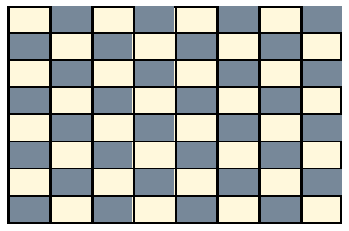

In [3]:
problema = ocho_reinas()
s = problema.estado_inicial()
problema.pintar_estado(s)
print("Problema solucionado?", problema.test_objetivo(s))

### Árboles de búsqueda

Una vez definido el espacio de estados del problema, realizamos la búsqueda de una solución mediante un árbol de búsqueda. Recuerde que estamos considerando que una solución es una secuencia de acciones, que en nuestro caso resultará en una secuencia de posiciones en donde poner las damas.

La intuición detrás de la construcción del árbol de búsqueda es suficientemente intuitiva. Comenzamos con la raíz del árbol, la cual es el estado inicial del problema. Las aristas del árbol serán las acciones aplicables y los nodos los estados que se obtienen al realizar la correspondiente acción. Así pues, una solución será la rama que conduce desde la raíz hasta uno de los nodos que sea un estado objetivo del problema.

![](./imagenes/arbol.png)

El siguiente es el pseudocódigo del método de construcción del árbol, el cual explicaremos con un poco más de detalle a continuación:

![](./imagenes/tree_search.png)

El método itera sobre la *frontera*, la cual consiste en los nodos que vamos a ir expandiendo para formar el árbol. Iremos analizamos la frontera de manera iterativa hasta que se cumpla una de dos condiciones: la frontera es el conjunto vacío, en cuyo caso el problema no tiene solución; o el nodo sobre el cual se está trabajando es un estado objetivo, en cuyo caso la solución será la rama que va desde la raíz hasta el estado objetivo. 

En cualquier iteración, lo primero que debemos hacer es seleccionar un nodo `s` dentro de la frontera (sobre el método de selección volveremos más adelante; por el momento podemos asumir que se selecciona aleatoriamente). Luego debemos revisar si `s` es un estado objetivo. Si sí, regresaremos la solución; si no, debemos encontrar las acciones aplicables desde `s` y luego expandir la frontera con los estados que se obtienen a partir de las acciones aplicables.

Observe que no hemos dicho nada acerca de cómo seleccionar el nodo que se va a expandir. Esta elección es lo que constituirá la *estratégia de búsqueda*, sobre la cual volveremos más adelante.

**Implementación de los árboles**

In [4]:
class nodo:
    
    # Clase para crear los nodos
    
    def __init__(self, estado, madre, accion, costo):
        self.estado = estado
        self.madre = madre
        self.accion = accion
        self.costo = costo
        
def nodo_hijo(problema, madre, accion):
    
    # Función para crear un nuevo nodo
    # Input: problema, que es un objeto de clase ocho_reinas
    #        madre, que es un nodo,
    #        accion, que es una accion que genera el nodo a partir de la madre
    # Output: nodo

    return nodo(problema.transicion(madre.estado, accion),
                madre,
                accion,
                costo = madre.costo + problema.costo(madre.estado, accion)
               )

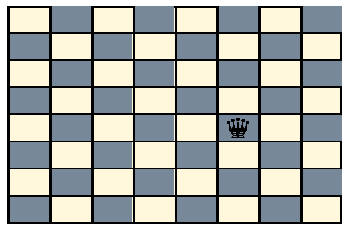

In [5]:
# Ejemplo de creación de un nuevo nodo a partir de la raíz
raiz = nodo(problema.estado_inicial(), None, None, 0)
acciones = problema.acciones_aplicables(raiz.estado)
a = choice(acciones)
n1 = nodo_hijo(problema, raiz, a)
problema.pintar_estado(n1.estado)

**Ejercicio 2:**

Implemente la función `solucion`, la cual toma un nodo `n`y devuelve la secuencia de acciones que va desde la raíz hasta `n`.

**Respuesta:**

Una posible implementación es la siguiente:

In [6]:
def solucion(n):
    
    # Devuelve la secuencia de estados que va desde la raíz
    # hasta el nodo n
    # Input: n, nodo
    # Output: l, lista de acciones
    
    acciones = []
    m = copy.deepcopy(n)
    while m.madre != None:
        acciones.append(m.accion)
        m = m.madre
    
    return acciones

---

**Ejercicio 3:**

Use una lista como la variable *frontera* para implementar la función `tree_search` y resolver el problema de las ocho damas.

**Respuesta:**

Una posible implementación es la siguiente:

In [7]:
def tree_search(problema):
    
    # Función de búsqueda mediante la construcción
    # del arbol de búsqueda de manera aleatoria
    
    raiz = nodo(problema.estado_inicial(), None, None, 0)
    
    frontera = [raiz]
    
    while len(frontera) > 0:
        # print("len(frontera)", len(frontera))
        n = choice(frontera)
        # print("*****************")
        # print(n.estado)
        frontera.remove(n)
        if problema.test_objetivo(n.estado):
            return n
        else:
            acciones = problema.acciones_aplicables(n.estado)
            # Limitamos las acciones aplicables a aquellas
            # que estan en la columna siguiente
            acciones_por_columna = [a for a in acciones if a[0]==n.estado.sum()]
            # print("\nAcciones posibles:")
            # print(acciones_por_columna)
            for a in acciones_por_columna[:3]: # Solo tomamos las 3 primeras
                N = nodo_hijo(problema, n, a)
                # print("Nodo a incluir:")
                # print(N.estado)
                frontera.append(N)
    
    return None

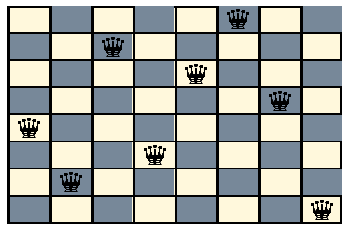

In [8]:
l = tree_search(problema)
if l: 
    problema.pintar_estado(l.estado)

---

**Ejercicio 4:**

Leer en el texto guía la discusión sobre caminos redundantes y el algoritmo `graph_search` (sección 3.3, págs. 76-77).

---

### Estrategias de búsqueda

**Breadth-first**

**Uniform-cost**

**Depth-first**